In [ ]:
from distributions_sampling_Copy2 import *
# from plots_utils import *
from fits_util import *
import timeit
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import timeit
import multiprocessing
from joblib import Parallel, delayed
np.random.seed(42)



Normalization Test Results:

Parameter Set 1: [3, 0.3, 1, 1.4, 0.3, 0, 2.5, 0.6]
  g_s(X): 1.000000
  h_s(Y): 1.000000
  g_b(X): 1.000000
  h_b(Y): 1.000000
  f(X, Y): 1.000000

Parameter Set 2: [2.9, 0.31, 1.1, 1.5, 0.4, 0.1, 2.6, 0.7]
  g_s(X): 1.000000
  h_s(Y): 1.000000
  g_b(X): 1.000000
  h_b(Y): 1.000000
  f(X, Y): 1.000000

Generating distribution plots for params_true...


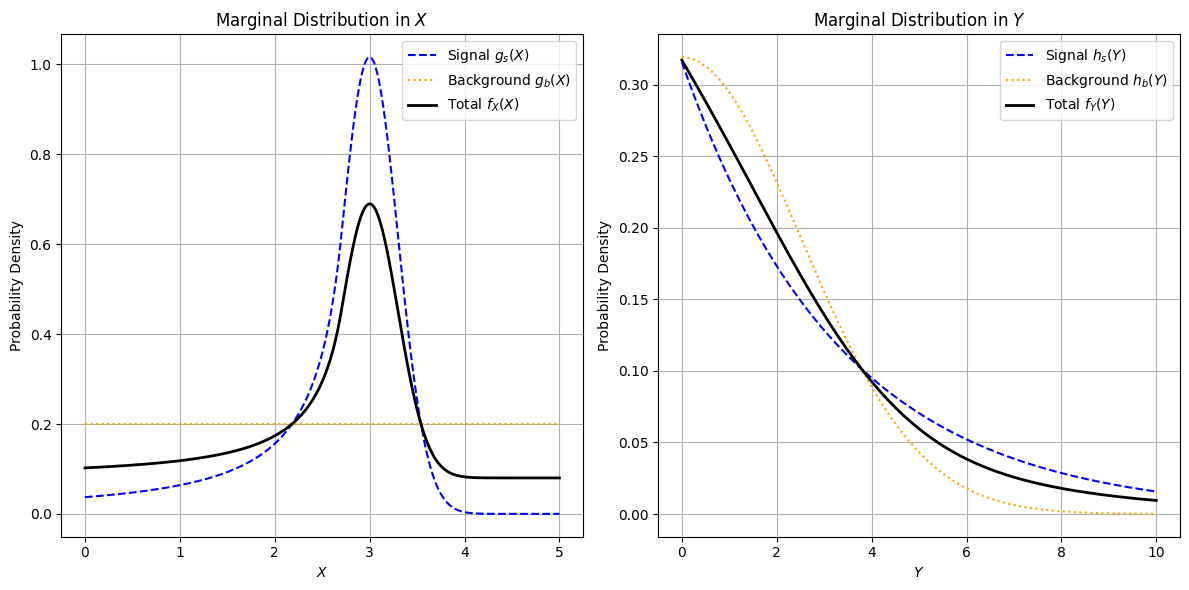

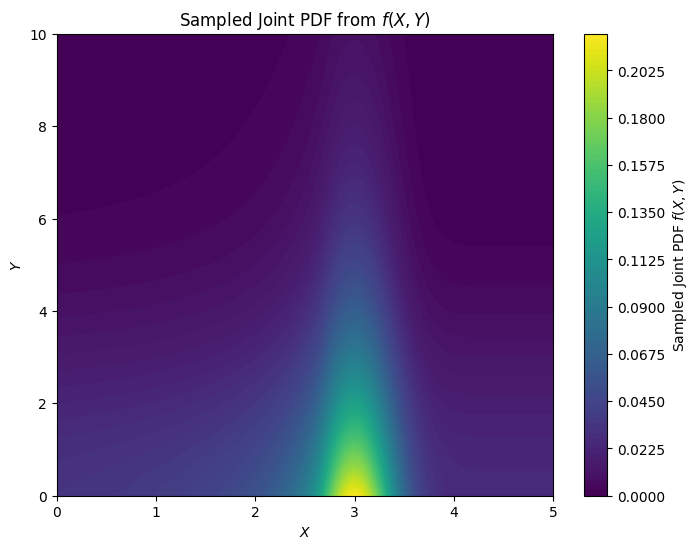


Generating sampled distribution plots...


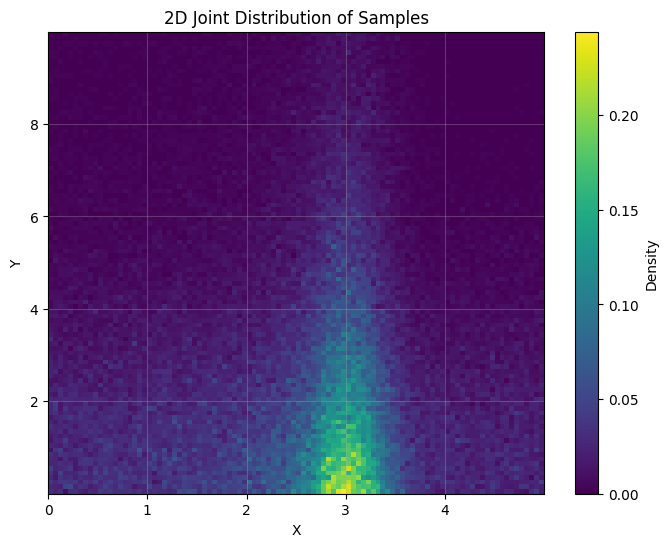

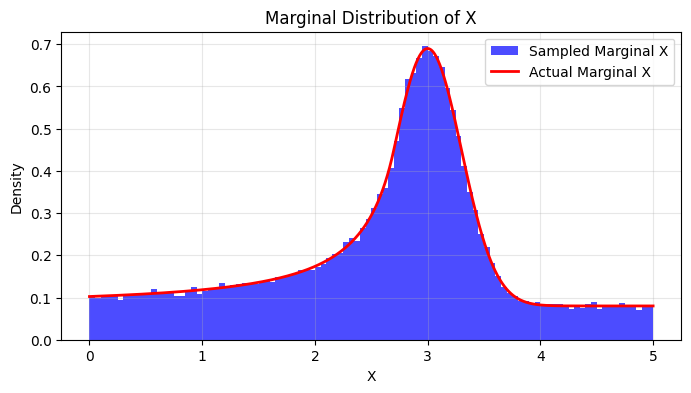

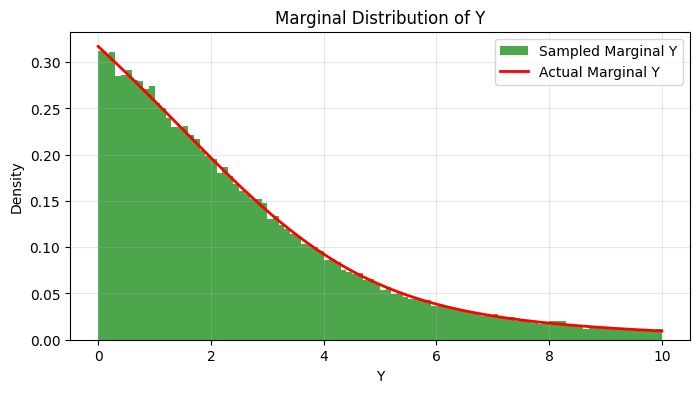

Fit converged successfully.
Fitted parameters: {'mu': 3.00135815026813, 'sigma': 0.29910130831256737, 'beta': 0.9827898938796182, 'm': 1.4459377344006286, 'lambda_s': 0.3001569220323265, 'mu_b': 0.09149845677191792, 'sigma_b': 2.4311573117622176, 'f_signal': 0.6009091701401148, 'N_expected': 100000.12039079433}
Uncertainties: {'mu': 0.0038017911102230517, 'sigma': 0.0035816999485647483, 'beta': 0.033348452265893225, 'm': 0.0963281709731949, 'lambda_s': 0.0029019166784909622, 'mu_b': 0.11026639741451771, 'sigma_b': 0.05276155486021805, 'f_signal': 0.004995992205615418, 'N_expected': 446.61821116137435}

Fit successful! Fitted parameters:
  mu: 3.0014
  sigma: 0.2991
  beta: 0.9828
  m: 1.4459
  lambda_s: 0.3002
  mu_b: 0.0915
  sigma_b: 2.4312
  f_signal: 0.6009
  N_expected: 100000.1204

Minuit Fit Diagnostics:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├────────────────────────

In [1]:
from plots_utils import *
from distributions_sampling_Copy2 import *
import numpy as np

# Parameters for testing
params_true = [3, 0.3, 1, 1.4, 0.3, 0, 2.5, 0.6]
params_normalization = [params_true,
                        [2.9, 0.31, 1.1, 1.5, 0.4, 0.1, 2.6, 0.7]]  # List of parameter sets for normalization

# Corrected bounds definition
bounds = {
    "mu": (2.8, 3.2),
    "sigma": (0.05, 0.5),
    "beta": (0.5, 1.5),
    "m": (1.0, 2.0),
    "lambda_s": (0.1, 1.0),
    "mu_b": (-1, 1),
    "sigma_b": (2.0, 4.0),
    "f_signal": (0.1, 0.9),
    "N_expected": (0.95 * 100000, 1.05 * 100000)
}

# Parameter labels for the correlation matrix
param_labels = ["mu", "sigma", "beta", "m", "lambda_s", "mu_b", "sigma_b", "f_signal", "mu_total"]

# Step 1: Test normalization for each parameter set
print("Normalization Test Results:")
for i, params in enumerate(params_normalization):
    results = test_normalization(params, 10000)  # Call the test_normalization function for each parameter set
    print(f"\nParameter Set {i + 1}: {params}")
    for dist, value in results.items():
        print(f"  {dist}: {value:.6f}")

# Step 2: Plot distributions for params_true
print("\nGenerating distribution plots for params_true...")
plot_distributions(params_true)

x_samples, y_samples = sample_componentwise(100000, params_true)

# Step 4: Plot sampled distributions
print("\nGenerating sampled distribution plots...")
plot_sampled_distributions(x_samples, y_samples, params_true)
# Define initial guesses and bounds for the fit
initial_guess = {
    "mu": 3.0,
    "sigma": 0.3,
    "beta": 1.0,
    "m": 1.4,
    "lambda_s": 0.3,
    "mu_b": 0.0,
    "sigma_b": 2.5,
    "f_signal": 0.6,
    "N_expected": 100000
}

# Perform the fit and retrieve Minuit object
fit_result, m = perform_fit(x_samples, y_samples, bounds, initial_guess, return_minuit=True)

if fit_result["converged"]:
    print("\nFit successful! Fitted parameters:")
    for param, value in fit_result["parameters"].items():
        print(f"  {param}: {value:.4f}")
    
    # Display Minuit diagnostics
    print("\nMinuit Fit Diagnostics:")
    print(m)

else:
    print("\nFit failed. Cannot generate surface comparison or diagnostics.")


In [2]:
def time_benchmark(bounds, initial_guess, params, size=100000, n_calls=10):
    """
    Benchmark execution times for:
    1. np.random.normal
    2. Componentwise sample generation
    3. Maximum likelihood fitting using generated samples

    Parameters:
    - bounds: Bounds for parameter fitting (used to generate initial guesses).
    - initial_guess: Initial parameter guesses for the fit.
    - params: True model parameters used for sampling.
    - size: Number of events to generate.
    - n_calls: Number of calls to average for benchmarking.

    Returns:
    - normal_time: Time taken for np.random.normal.
    - sample_time: Time taken for sample generation.
    - fit_time: Time taken for maximum likelihood fitting.
    - sample_relative: Relative time for sample generation compared to np.random.normal.
    - fit_relative: Relative time for fitting compared to np.random.normal.
    """
    import timeit

    # 1. Benchmark np.random.normal
    normal_time = timeit.timeit(
        stmt="np.random.normal(0, 1, size=size)",  # Example normal sampling
        setup="import numpy as np",
        globals={"size": size},
        number=n_calls
    ) / n_calls

    # 2. Benchmark componentwise sample generation
    def generate_samples():
        return sample_componentwise(size, params)

    sample_time = timeit.timeit(
        stmt="generate_samples()",
        globals={"generate_samples": generate_samples},
        number=n_calls
    ) / n_calls

    # Generate a single sample for fitting
    x_samples, y_samples = sample_componentwise(size, params)

    # 3. Benchmark maximum likelihood fitting
    fit_time = timeit.timeit(
        stmt="perform_fit(x_samples, y_samples, bounds, initial_guess)",
        globals={"perform_fit": perform_fit, "x_samples": x_samples, "y_samples": y_samples, 
                 "bounds": bounds, "initial_guess": initial_guess},
        number=n_calls
    ) / n_calls

    # Compute relative times
    sample_relative = sample_time / normal_time
    fit_relative = fit_time / normal_time

    return normal_time, sample_time, fit_time, sample_relative, fit_relative

# True parameters for sampling
true_params = [3, 0.3, 1, 1.4, 0.3, 0, 2.5, 0.6]  # mu, sigma, beta, m, lambda_s, mu_b, sigma_b, f_signal

# Define bounds for the parameters
bounds = {
    "mu": (2.9, 3.1),           # mu
    "sigma": (0.05, 0.5),       # sigma
    "beta": (0.5, 1.5),         # beta
    "m": (1.0, 1.6),            # m
    "lambda_s": (0.2, 0.4),     # lambda_s
    "mu_b": (-0.1, 0.1),        # mu_b
    "sigma_b": (2.3, 2.7),      # sigma_b
    "f_signal": (0.1, 0.9),     # f_signal
    "N_expected": (95000, 105000)  # N_expected
}

# Define initial guesses for the fit
initial_guess = {
    "mu": 3, "sigma": 0.3, "beta": 1, "m": 1.4, 
    "lambda_s": 0.3, "mu_b": 0, "sigma_b": 2.5, 
    "f_signal": 0.6, "N_expected": 100000
}

# Benchmarking settings
size = 100000  # Number of samples
n_calls = 100  # Number of repetitions for benchmarking

# Run the benchmark
print("\nBenchmarking execution times...")
normal_time, sample_time, fit_time, sample_relative, fit_relative = time_benchmark(
    bounds, initial_guess, true_params, size, n_calls
)

# Display results
print("\nExecution Times (averaged over {} calls):".format(n_calls))
print(f"(i) np.random.normal: {normal_time:.6e} seconds")
print(f"(ii) Componentwise sample generation: {sample_time:.6e} seconds")
print(f"(iii) Maximum likelihood fit: {fit_time:.6e} seconds")

print("\nRelative Times:")
print(f"Sample generation relative to np.random.normal: {sample_relative:.2f}")
print(f"Fit relative to np.random.normal: {fit_relative:.2f}")



Benchmarking execution times...
Fit converged successfully.
Fitted parameters: {'mu': 3.0009432345465297, 'sigma': 0.30104792261702534, 'beta': 0.9733269293219895, 'm': 1.4836032365499678, 'lambda_s': 0.3001589751837027, 'mu_b': 0.04486114261679264, 'sigma_b': 2.4799253246317106, 'f_signal': 0.596944029343194, 'N_expected': 100000.07595932542}
Uncertainties: {'mu': 0.0036569941186843646, 'sigma': 0.003456248742623541, 'beta': 0.030711203179084545, 'm': 0.09370731732030235, 'lambda_s': 0.0029211823230146927, 'mu_b': 0.15801118131080455, 'sigma_b': 0.05243848234234494, 'f_signal': 0.005062575977250738, 'N_expected': 446.6204502021792}
Fit converged successfully.
Fitted parameters: {'mu': 3.0009432345465297, 'sigma': 0.30104792261702534, 'beta': 0.9733269293219895, 'm': 1.4836032365499678, 'lambda_s': 0.3001589751837027, 'mu_b': 0.04486114261679264, 'sigma_b': 2.4799253246317106, 'f_signal': 0.596944029343194, 'N_expected': 100000.07595932542}
Uncertainties: {'mu': 0.0036569941186843646,

Fit converged successfully.
Fitted parameters: {'mu': 3.054321984113775, 'sigma': 0.3107818707456229, 'beta': 0.8728648911349817, 'm': 1.999979570866178, 'lambda_s': 0.2786535153370462, 'mu_b': -0.09999542389363919, 'sigma_b': 2.391265094318588, 'f_signal': 0.6165362832574597, 'N_expected': 459.00014209221314}
Uncertainties: {'mu': 0.05289820010378188, 'sigma': 0.05136035939308256, 'beta': 0.17882441516882502, 'm': 0.8673636267497711, 'lambda_s': 0.04132491520522466, 'mu_b': 0.10055350353372446, 'sigma_b': 0.2733521797150853, 'f_signal': 0.06662729821190783, 'N_expected': 34.06661686491154}
Fit converged successfully.
Fitted parameters: {'mu': 3.0565208766926557, 'sigma': 0.30762994996835435, 'beta': 0.8003509044562758, 'm': 1.8258715634093836, 'lambda_s': 0.27903629540032093, 'mu_b': 0.09999941004995905, 'sigma_b': 2.429523437335659, 'f_signal': 0.6137488335261168, 'N_expected': 512.0001627840336}
Uncertainties: {'mu': 0.04868741064065807, 'sigma': 0.04594253814194449, 'beta': 0.48207

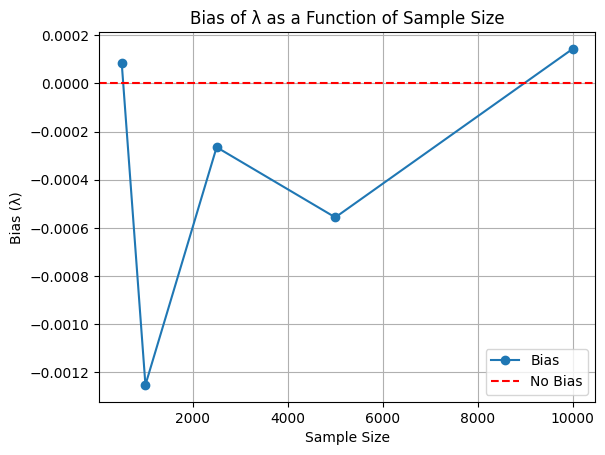

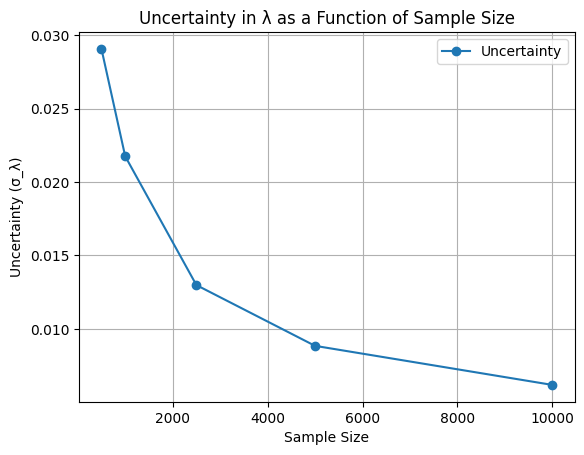


Sample Size: 500
  mu: 2.9980
  sigma: 0.2988
  beta: 1.0137
  m: 1.4675
  lambda_s: 0.3001
  mu_b: 0.0149
  sigma_b: 2.4942
  f_signal: 0.6016
  N_expected: 499.8314

Sample Size: 1000
  mu: 3.0012
  sigma: 0.2990
  beta: 1.0301
  m: 1.3960
  lambda_s: 0.2987
  mu_b: 0.0080
  sigma_b: 2.4737
  f_signal: 0.5997
  N_expected: 1000.3581

Sample Size: 2500
  mu: 3.0014
  sigma: 0.2981
  beta: 1.0060
  m: 1.4297
  lambda_s: 0.2997
  mu_b: 0.0100
  sigma_b: 2.4922
  f_signal: 0.5995
  N_expected: 2496.1300

Sample Size: 5000
  mu: 2.9998
  sigma: 0.3001
  beta: 1.0143
  m: 1.4007
  lambda_s: 0.2994
  mu_b: 0.0061
  sigma_b: 2.4991
  f_signal: 0.5994
  N_expected: 5001.4187

Sample Size: 10000
  mu: 3.0001
  sigma: 0.3003
  beta: 0.9995
  m: 1.4114
  lambda_s: 0.3001
  mu_b: -0.0016
  sigma_b: 2.5020
  f_signal: 0.6006
  N_expected: 9990.7470


In [55]:
import numpy as np
import matplotlib.pyplot as plt

def bootstrap_study(bounds, true_lambda, params, n_trials=250):
    """
    Perform a bootstrap simulation study to evaluate bias and uncertainty in the fitted `lambda` parameter.

    Args:
        bounds: Parameter bounds for the fit (excluding N_expected).
        true_lambda: True value of the decay constant (λ) to compare bias.
        params: True model parameters for sampling.
        n_trials: Number of bootstrap trials for each sample size.

    Returns:
        results: A dictionary containing biases, uncertainties, sample sizes, and average parameters.
    """
    sample_sizes = [500, 1000, 2500, 5000, 10000]
    results = {
        "sample_size": [],
        "mean_lambda": [],
        "std_lambda": [],
        "bias": [],
        "average_parameters": {},  # To store average fitted parameters for each sample size
    }

    for sample_size in sample_sizes:
        fitted_lambdas = []
        fitted_parameters = {param: [] for param in bounds.keys()}  # Collect all fitted params

        for _ in range(n_trials):
            # Generate Poisson variation of sample size
            poisson_sample_size = np.random.poisson(sample_size)

            # Generate samples using the new sampling function
            x_samples, y_samples = sample_componentwise(poisson_sample_size, params)

            # Define initial guesses for the fit
            initial_guess = {
                "mu": 3.0,        # True value
                "sigma": 0.35,    # True value
                "beta": 1.2,      # True value
                "m": 1.5,         # True value
                "lambda_s": 0.3,  # True value
                "mu_b": 0.0,      # True value
                "sigma_b": 2.5,   # True value
                "f_signal": 0.5,  # True value
                "N_expected": poisson_sample_size,  # Poisson variation
            }

            # Dynamically set bounds for N_expected based on the Poisson sample size
            dynamic_bounds = bounds.copy()
            dynamic_bounds["N_expected"] = (
                0.95 * poisson_sample_size,
                1.05 * poisson_sample_size,
            )

            # Perform fit using the new fitting function
            fit_result = perform_fit(x_samples, y_samples, dynamic_bounds, initial_guess)

            # Collect fitted lambda value and other parameters if the fit converged
            if fit_result["converged"]:
                fitted_lambdas.append(fit_result["parameters"]["lambda_s"])
                for param in fit_result["parameters"]:
                    fitted_parameters[param].append(fit_result["parameters"][param])

        # Calculate bias and uncertainty for the current sample size
        mean_lambda = np.mean(fitted_lambdas)
        std_lambda = np.std(fitted_lambdas)
        bias = mean_lambda - true_lambda

        # Store average fitted parameters for this sample size
        avg_params = {param: np.mean(values) for param, values in fitted_parameters.items()}
        results["average_parameters"][sample_size] = avg_params

        # Store results
        results["sample_size"].append(sample_size)
        results["mean_lambda"].append(mean_lambda)
        results["std_lambda"].append(std_lambda)
        results["bias"].append(bias)

        print(f"Sample Size: {sample_size}, Bias: {bias:.4f}, Uncertainty: {std_lambda:.4f}")

    return results


def plot_bootstrap_results(results):
    """
    Plot the bias and uncertainty as functions of sample size.
    """
    sample_sizes = results["sample_size"]
    biases = results["bias"]
    uncertainties = results["std_lambda"]

    # Plot bias vs sample size
    plt.figure()
    plt.plot(sample_sizes, biases, marker="o", label="Bias")
    plt.axhline(0, color="r", linestyle="--", label="No Bias")
    plt.xlabel("Sample Size")
    plt.ylabel("Bias (λ)")
    plt.title("Bias of λ as a Function of Sample Size")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot uncertainty vs sample size
    plt.figure()
    plt.plot(sample_sizes, uncertainties, marker="o", label="Uncertainty")
    plt.xlabel("Sample Size")
    plt.ylabel("Uncertainty (σ_λ)")
    plt.title("Uncertainty in λ as a Function of Sample Size")
    plt.legend()
    plt.grid()
    plt.show()


def report_average_parameters(results):
    """
    Print the average fitted parameters for each sample size.
    """
    for sample_size, avg_params in results["average_parameters"].items():
        print(f"\nSample Size: {sample_size}")
        for param, value in avg_params.items():
            print(f"  {param}: {value:.4f}")


# Define bounds for the parameters
bounds = {
    "mu": (2.8, 3.2),          # Reasonable range around the true value of 3
    "sigma": (0.2, 0.4),       # Narrow range around the true value of 0.3
    "beta": (0.8, 1.5),        # Close to the true value of 1
    "m": (1.0, 2.0),           # Narrow around the true value of 1.4
    "lambda_s": (0.2, 0.5),    # Includes the true value of 0.3
    "mu_b": (-0.1, 0.1),       # Close to the true value of 0
    "sigma_b": (2.0, 3.0),     # Around the true value of 2.5
    "f_signal": (0.3, 0.9),    # Includes the true value of 0.6
    "N_expected": (95000, 105000),  # Adjusted dynamically per trial
}

# Perform the bootstrap study
true_lambda = 0.3  # True decay constant
params = [3, 0.3, 1, 1.4, 0.3, 0, 2.5, 0.6]  # True model parameters for sampling
results = bootstrap_study(bounds, true_lambda, params)

# Plot results
plot_bootstrap_results(results)

# Report average parameters
report_average_parameters(results)


Sample Size: 500, Bias: 0.0402, Uncertainty: 0.0245
Sample Size: 1000, Bias: 0.0406, Uncertainty: 0.0172
Sample Size: 2500, Bias: 0.0391, Uncertainty: 0.0108
Sample Size: 5000, Bias: 0.0392, Uncertainty: 0.0077
Sample Size: 10000, Bias: 0.0395, Uncertainty: 0.0054

Average Fitted X Parameters:
Sample Size: 500
  mu: 3.0192
  sigma: 0.2064
  beta: 1.4244
  m: 1.8920
  f_signal: 0.8808
  N_expected: 451.3968
Sample Size: 1000
  mu: 2.9840
  sigma: 0.2000
  beta: 1.4720
  m: 1.9600
  f_signal: 0.9000
  N_expected: 900.7848
Sample Size: 2500
  mu: 3.0288
  sigma: 0.2000
  beta: 1.4944
  m: 1.9920
  f_signal: 0.9000
  N_expected: 2249.7588
Sample Size: 5000
  mu: 3.0032
  sigma: 0.2000
  beta: 1.5000
  m: 2.0000
  f_signal: 0.9000
  N_expected: 4500.7272
Sample Size: 10000
  mu: 3.0112
  sigma: 0.2000
  beta: 1.5000
  m: 2.0000
  f_signal: 0.9000
  N_expected: 9004.4892


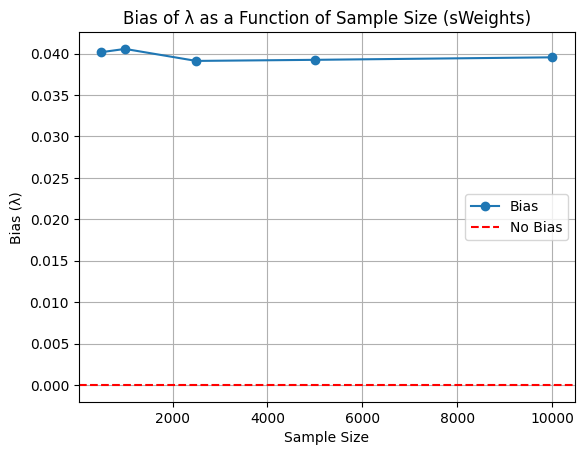

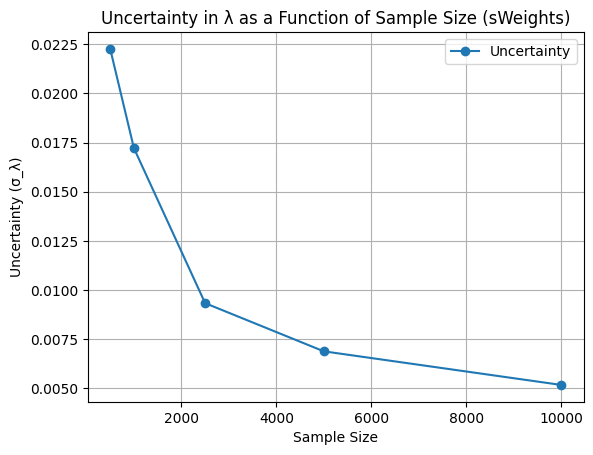

In [40]:
import matplotlib.pyplot as plt
from scipy.stats import poisson
# from scipy.optimize import minimize, minimize_scalar
import numpy as np
from iminuit import Minuit

from iminuit import Minuit
def perform_fit_for_x_only_with_iminuit(x_samples, bounds_x):
    """
    Perform an extended maximum likelihood fit to the X-variable only using iminuit,
    including the calculation of uncertainties with m.hesse().
    """
    n_events = len(x_samples)  # Observed number of events

    # Define the negative log-likelihood function for X only
    def negative_log_likelihood_x(mu, sigma, beta, m, f_signal, N_expected):
        # Compute g_s normalization for current parameters
        g_s_norm = crystal_ball_normalization_truncated(mu, sigma, beta, m, lower=0, upper=5)
        
        # Evaluate g_s(X) and g_b(X)
        g_s_vals = g_s_vectorized(x_samples, mu, sigma, beta, m, g_s_norm)
        g_b_vals = g_b_vectorized(x_samples)
        
        # Combined PDF
        f_x_vals = f_signal * g_s_vals + (1 - f_signal) * g_b_vals
        
        # Clamp values for numerical stability
        f_x_vals_safe = np.maximum(f_x_vals, 1e-8)
        
        # Extended negative log-likelihood
        log_likelihood = (
            -N_expected + n_events * np.log(N_expected) + np.sum(np.log(f_x_vals_safe))
        )
        return log_likelihood

    # Initialize iminuit with parameters and initial guesses
    m = Minuit(
        negative_log_likelihood_x,
        mu=3.0, sigma=0.3, beta=1.0, m=1.4, f_signal=0.6, N_expected=n_events
    )

    # Set parameter bounds
    m.limits = (
        bounds_x["mu"],
        bounds_x["sigma"],
        bounds_x["beta"],
        bounds_x["m"],
        bounds_x["f_signal"],
        (0.9 * n_events, 1.1 * n_events),  # Bounds for N_expected
    )

    # Run the minimization
    m.migrad()  # Perform the fit

    if not m.valid:
        raise RuntimeError("Fit for X failed!")

    # Calculate uncertainties using m.hesse()
    m.hesse()

    # Return fitted parameters as a dictionary
    return {param: m.values[param] for param in m.parameters}


# Step 2: Compute sWeights
def compute_sweights(x_samples, fitted_params_x):
    """
    Compute sWeights for the signal projection based on the fitted X parameters.
    """
    mu, sigma, beta, m, f_signal, _ = fitted_params_x
    
    # Compute g_s normalization
    g_s_norm = crystal_ball_normalization_truncated(mu, sigma, beta, m, lower=0, upper=5)
    
    # Compute signal and background PDFs for X
    g_s_vals = g_s_vectorized(x_samples, mu, sigma, beta, m, g_s_norm)
    g_b_vals = g_b_vectorized(x_samples)
    
    # Calculate signal weights
    weights_signal = f_signal * g_s_vals / (f_signal * g_s_vals + (1 - f_signal) * g_b_vals)
    return weights_signal

def fit_y_with_iminuit(y_samples, sweights):
    """
    Perform a weighted fit on the Y-dimension using iminuit, with uncertainties calculated using m.hesse().
    """
    def negative_log_likelihood_y(lambda_s):
        h_s_vals = h_s_vectorized(y_samples, lambda_s)
        likelihood = sweights * np.log(np.maximum(h_s_vals, 1e-8))
        return -np.sum(likelihood)

    # Initialize iminuit
    m = Minuit(negative_log_likelihood_y, lambda_s=0.3)

    # Set parameter bounds
    m.limits["lambda_s"] = (0.2, 0.4)

    # Perform the fit
    m.migrad()

    if not m.valid:
        raise RuntimeError("Fit for Y failed!")

    # Calculate uncertainties using m.hesse()
    m.hesse()

    # Return the fitted parameter, uncertainty, and validity
    return m.values["lambda_s"], m.errors["lambda_s"], m.valid
def sweight_bootstrap_study(bounds, true_lambda, params, n_trials=250):
    """
    Perform a bootstrap study using sWeights for bias and uncertainty evaluation of λ.
    """
    sample_sizes = [500, 1000, 2500, 5000, 10000]
    results = {
        "sample_size": [],
        "mean_lambda": [],
        "std_lambda": [],
        "bias": [],
        "average_x_parameters": {},  # To store average X fit parameters for each sample size
    }

    for sample_size in sample_sizes:
        fitted_lambdas = []
        uncertainties = []
        fitted_x_parameters = []  # Collect all X parameters for averaging

        for _ in range(n_trials):
            # Generate Poisson variation of sample size
            poisson_sample_size = np.random.poisson(sample_size)

            # Generate samples
            x_samples, y_samples = sample_componentwise(poisson_sample_size, params)

            # Fit X-dimension to compute sWeights
            try:
                fitted_params_x = perform_fit_for_x_only_with_iminuit(x_samples, bounds)
                fitted_x_parameters.append(fitted_params_x)  # Store fitted X parameters
                sweights = compute_sweights(x_samples, list(fitted_params_x.values()))
            except RuntimeError:
                continue

            # Fit Y-dimension using sWeights
            lambda_mle, uncertainty, success = fit_y_with_sweights(y_samples, sweights)

            if success:
                fitted_lambdas.append(lambda_mle)
                uncertainties.append(uncertainty)

        # Calculate bias and uncertainty for the current sample size
        mean_lambda = np.mean(fitted_lambdas)
        std_lambda = np.std(fitted_lambdas)
        bias = mean_lambda - true_lambda

        # Calculate average X parameters for this sample size
        avg_x_params = {key: np.mean([params[key] for params in fitted_x_parameters]) for key in fitted_x_parameters[0]}
        results["average_x_parameters"][sample_size] = avg_x_params

        # Store results
        results["sample_size"].append(sample_size)
        results["mean_lambda"].append(mean_lambda)
        results["std_lambda"].append(std_lambda)
        results["bias"].append(bias)

        print(f"Sample Size: {sample_size}, Bias: {bias:.4f}, Uncertainty: {np.mean(uncertainties):.4f}")

    return results

def display_average_x_parameters(results):
    """
    Display the average fitted X parameters for each sample size.
    """
    print("\nAverage Fitted X Parameters:")
    for sample_size, avg_params in results["average_x_parameters"].items():
        print(f"Sample Size: {sample_size}")
        for param_name, param_value in avg_params.items():
            print(f"  {param_name}: {param_value:.4f}")


def plot_sweight_bootstrap_results(results):
    """
    Plot the bias and uncertainty as functions of sample size.
    """
    sample_sizes = results["sample_size"]
    biases = results["bias"]
    uncertainties = results["std_lambda"]

    # Plot bias vs sample size
    plt.figure()
    plt.plot(sample_sizes, biases, marker="o", label="Bias")
    plt.axhline(0, color="r", linestyle="--", label="No Bias")
    plt.xlabel("Sample Size")
    plt.ylabel("Bias (λ)")
    plt.title("Bias of λ as a Function of Sample Size (sWeights)")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot uncertainty vs sample size
    plt.figure()
    plt.plot(sample_sizes, uncertainties, marker="o", label="Uncertainty")
    plt.xlabel("Sample Size")
    plt.ylabel("Uncertainty (σ_λ)")
    plt.title("Uncertainty in λ as a Function of Sample Size (sWeights)")
    plt.legend()
    plt.grid()
    plt.show()


# Perform the study
true_lambda = 0.3  # True decay constant
params = [3, 0.3, 1, 1.4, 0.3, 0, 2.5, 0.6]  # True model parameters for sampling

# Define bounds for X fit
bounds_x = {
    "mu": (2.8, 3.2),          # Reasonable range around the true value of 3
    "sigma": (0.2, 0.4),       # Narrow range around the true value of 0.3
    "beta": (0.8, 1.5),        # Close to the true value of 1
    "m": (1.0, 2.0),           # Narrow around the true value of 1.4
    "f_signal": (0.3, 0.9),    # Includes the true value of 0.6
}

# Perform the bootstrap study
results_sweights = sweight_bootstrap_study(bounds_x, true_lambda, params)

# Display average X parameters
display_average_x_parameters(results_sweights)

# Plot results
plot_sweight_bootstrap_results(results_sweights)




Sample Size: 500, Bias: 0.0412, Uncertainty: 0.0234
Sample Size: 1000, Bias: 0.0399, Uncertainty: 0.0146
Sample Size: 2500, Bias: 0.0405, Uncertainty: 0.0094
Sample Size: 5000, Bias: 0.0404, Uncertainty: 0.0072
Fit in X failed on attempt 1: Fit did not converge
Fit in X failed on attempt 2: Fit did not converge
Fit in X failed on attempt 3: Fit did not converge
Fit in X did not converge after maximum retries. Skipping iteration.
Sample Size: 10000, Bias: 0.0401, Uncertainty: 0.0049
Sample Size: 30000, Bias: 0.0399, Uncertainty: 0.0030


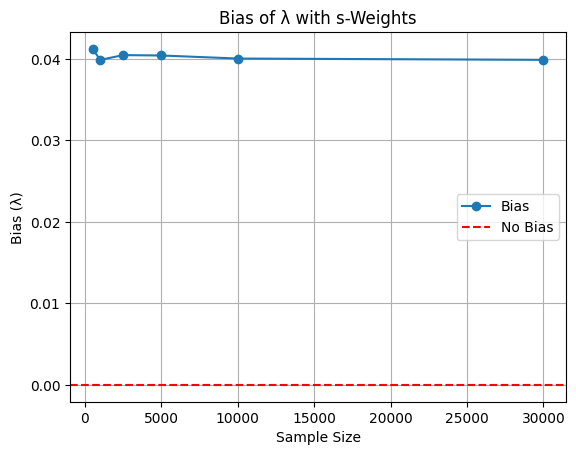

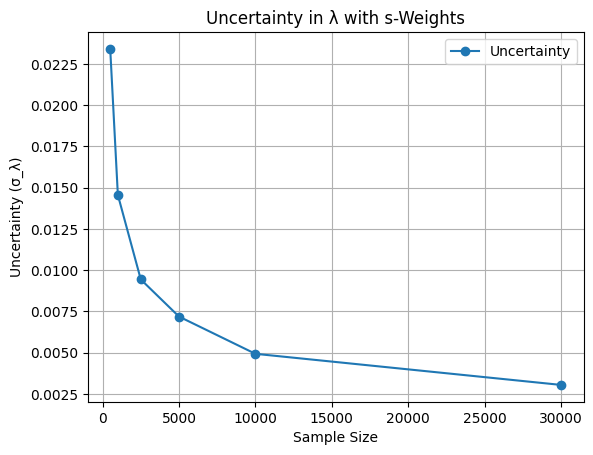

In [56]:
from iminuit import Minuit
import numpy as np

def fit_X(x_samples, bounds, initial_guess):
    """
    Perform an extended likelihood fit in the X dimension only.

    Args:
        x_samples (array): Array of X samples.
        bounds (dict): A dictionary of parameter bounds for the fit.
        initial_guess (dict): A dictionary of initial parameter guesses.

    Returns:
        dict: Fitted parameters, uncertainties, and s-weights for each sample.
    """
    def negative_log_likelihood(mu, sigma, beta, m, f_signal, N_expected):
        try:
            # Precompute normalization constant for g_s(X)
            g_s_norm = crystal_ball_normalization_truncated(mu, sigma, beta, m, lower=0, upper=5)

            # Compute the signal and background PDFs
            signal_pdf = g_s_vectorized(x_samples, mu, sigma, beta, m, g_s_norm)
            background_pdf = g_b_vectorized(x_samples)
            
            # Combine signal and background PDFs
            pdf_vals = f_signal * signal_pdf + (1 - f_signal) * background_pdf

            # Ensure numerical stability
            pdf_vals += 1e-10

            # Extended likelihood terms
            log_likelihood = (
                -N_expected
                + len(x_samples) * np.log(N_expected)
                + np.sum(np.log(pdf_vals))
            )

            return -log_likelihood
        except Exception as e:
            print(f"Error in likelihood calculation: {e}")
            return 1e10

    # Initialize Minuit for the fit
    m = Minuit(negative_log_likelihood, **initial_guess)

    # Set bounds
    for param, bound in bounds.items():
        m.limits[param] = bound

    # Perform the fit
    m.migrad()
    m.hesse()

    if not m.valid:
        raise ValueError("Fit did not converge")

    # Extract the fitted parameters
    params = {name: value for name, value in zip(m.parameters, m.values)}

    # Calculate s-weights
    g_s_norm = crystal_ball_normalization_truncated(
        params["mu"], params["sigma"], params["beta"], params["m"], lower=0, upper=5
    )
    signal_pdf = g_s_vectorized(x_samples, params["mu"], params["sigma"], params["beta"], params["m"], g_s_norm)
    background_pdf = g_b_vectorized(x_samples)
    s_weights = (params["f_signal"] * signal_pdf) / (
        params["f_signal"] * signal_pdf + (1 - params["f_signal"]) * background_pdf
    )

    return {
        "parameters": params,
        "uncertainties": {name: error for name, error in zip(m.parameters, m.errors)},
        "s_weights": s_weights
    }

def fit_Y_weighted(y_samples, s_weights, bounds, initial_guess):
    """
    Perform a weighted fit in the Y dimension using s-weights.

    Args:
        y_samples (array): Array of Y samples.
        s_weights (array): Array of s-weights.
        bounds (dict): Bounds for the fit.
        initial_guess (dict): Initial guesses for the fit.

    Returns:
        dict: Fitted parameters and uncertainties for λ.
    """
    def weighted_negative_log_likelihood(lambda_s):
        try:
            # Compute the signal PDF h_s(Y)
            signal_pdf = h_s_vectorized(y_samples, lambda_s)

            # Weighted likelihood
            weighted_likelihood = s_weights * np.log(signal_pdf + 1e-10)
            return -np.sum(weighted_likelihood)
        except Exception as e:
            print(f"Error in likelihood calculation: {e}")
            return 1e10

    # Initialize Minuit
    m = Minuit(weighted_negative_log_likelihood, **initial_guess)

    # Set bounds
    for param, bound in bounds.items():
        m.limits[param] = bound

    # Perform the fit
    m.migrad()
    m.hesse()

    if not m.valid:
        raise ValueError("Fit did not converge")

    # Return the results
    return {
        "parameters": {name: value for name, value in zip(m.parameters, m.values)},
        "uncertainties": {name: error for name, error in zip(m.parameters, m.errors)}
    }
    
def bootstrap_s_weights_with_poisson(bounds_X, bounds_Y, true_lambda, params, n_trials=250, max_retries=3):
    
    """
    Perform a bootstrap simulation study with Poisson variation on sample size.

    Args:
        bounds_X: Parameter bounds for the fit in X.
        bounds_Y: Parameter bounds for the fit in Y.
        true_lambda: True value of the decay constant λ to compare bias.
        params: True model parameters for sampling.
        n_trials: Number of bootstrap trials for each sample size.
        max_retries: Maximum number of retries for the fit in X.

    Returns:
        results: A dictionary containing biases, uncertainties, and sample sizes.
    """
    sample_sizes = [500, 1000, 2500, 5000, 10000, 30000]
    results = {
        "sample_size": [],
        "mean_lambda": [],
        "std_lambda": [],
        "bias": []
    }

    for sample_size in sample_sizes:
        fitted_lambdas = []

        for _ in range(n_trials):
            # Apply Poisson variation to the sample size
            poisson_sample_size = np.random.poisson(sample_size)

            # Generate samples
            x_samples, y_samples = sample_componentwise(poisson_sample_size, params)

            # Retry logic for the fit in X
            fit_X_result = None
            for attempt in range(max_retries):
                try:
                    # Fit in X
                    initial_guess_X = {
                        "mu": 3.1,        # Close to true value
                        "sigma": 0.32,     # True value
                        "beta": 0.9,      # True value
                        "m": 1.5,         # True value
                        "f_signal": 0.7,  # True value
                        "N_expected": poisson_sample_size  # Match initial guess to Poisson variation
                    }

                    # Dynamically set bounds for N_expected based on the Poisson sample size
                    dynamic_bounds_X = bounds_X.copy()
                    dynamic_bounds_X["N_expected"] = (
                        0.95 * poisson_sample_size,
                        1.05 * poisson_sample_size
                    )

                    # Perform the fit in X
                    fit_X_result = fit_X(x_samples, dynamic_bounds_X, initial_guess_X)
                    break  # Exit retry loop if fit succeeds

                except ValueError as e:
                    print(f"Fit in X failed on attempt {attempt + 1}: {e}")
                    # Perturb initial guesses slightly for the next attempt
                    initial_guess_X = {
                        k: v * (1 + 0.1 * np.random.uniform(-1, 1))
                        for k, v in initial_guess_X.items()
                    }

            if fit_X_result is None:
                print("Fit in X did not converge after maximum retries. Skipping iteration.")
                continue  # Skip this iteration if fit in X fails

            try:
                # Use the s-weights from the successful fit in X
                s_weights = fit_X_result["s_weights"]

                # Fit in Y using s-weights
                initial_guess_Y = {"lambda_s": 0.3}
                fit_Y_result = fit_Y_weighted(y_samples, s_weights, bounds_Y, initial_guess_Y)

                # Collect the fitted λ value
                fitted_lambdas.append(fit_Y_result["parameters"]["lambda_s"])

            except ValueError as e:
                print(f"Fit in Y failed: {e}")
                continue  # Skip this iteration if fit in Y fails

        # Calculate bias and uncertainty for the current sample size, if any fits succeeded
        if fitted_lambdas:
            mean_lambda = np.mean(fitted_lambdas)
            std_lambda = np.std(fitted_lambdas)
            bias = mean_lambda - true_lambda

            # Store results
            results["sample_size"].append(sample_size)
            results["mean_lambda"].append(mean_lambda)
            results["std_lambda"].append(std_lambda)
            results["bias"].append(bias)

            print(f"Sample Size: {sample_size}, Bias: {bias:.4f}, Uncertainty: {std_lambda:.4f}")
        else:
            print(f"No successful fits for sample size {sample_size}. Results will not be recorded.")

    return results

def plot_results(results):
    sample_sizes = results["sample_size"]
    biases = results["bias"]
    uncertainties = results["std_lambda"]

    # Plot bias
    plt.figure()
    plt.plot(sample_sizes, biases, marker="o", label="Bias")
    plt.axhline(0, color="r", linestyle="--", label="No Bias")
    plt.xlabel("Sample Size")
    plt.ylabel("Bias (λ)")
    plt.title("Bias of λ with s-Weights")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot uncertainty
    plt.figure()
    plt.plot(sample_sizes, uncertainties, marker="o", label="Uncertainty")
    plt.xlabel("Sample Size")
    plt.ylabel("Uncertainty (σ_λ)")
    plt.title("Uncertainty in λ with s-Weights")
    plt.legend()
    plt.grid()
    plt.show()

# Define bounds for X and Y fits
bounds_X = {
    "mu": (2.9, 3.1),         # Wider range for mu
    "sigma": (0.1, 0.5),      # Allow more flexibility for sigma
    "beta": (0.5, 2.0),       # Include a wider range for beta
    "m": (1.0, 3.0),          # Expand m range
    "f_signal": (0.1, 1.0),   # Include full range for f_signal
    "N_expected": (400, 600)  # Allow variation in expected sample size
}

bounds_Y = {
    "lambda_s": (0.2, 0.5)
}

# Run bootstrap study
true_lambda = 0.3
params = [3, 0.3, 1, 1.4, 0.3, 0, 2.5, 0.6]  # True model parameters
results = bootstrap_s_weights_with_poisson(bounds_X, bounds_Y, true_lambda, params)

# Plot results
plot_results(results)
